# Statistical analysis eval runs

## Setup

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
pd.set_option("display.width", 100)
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
import seaborn as sns

from scipy import stats
import math

from collections import Counter

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)




### Load files

In [3]:
experiments = pd.read_csv('../evaluation/resources/2020/all_experiments_eval.csv')
experiments.source = experiments.source.apply(lambda row: row.replace('_TREC-Fair-Ranking-eval-sample-full-annotations-DocLevel-mixed_group-qrels_EEL',''))
experiments

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source,system
0,0.23910,1.42244,1.24913,0.14971,0.03529,0.01117,95,ac_controller_default_lm,LM + AC_dtd
1,0.76381,1.77053,1.38972,0.44681,0.17976,0.08696,612,ac_controller_default_lm,LM + AC_dtd
2,2.69675,1.76200,0.32276,0.77073,0.11388,0.06241,657,ac_controller_default_lm,LM + AC_dtd
3,0.17600,1.81185,1.29111,0.67444,0.25027,0.17895,771,ac_controller_default_lm,LM + AC_dtd
4,0.37616,1.73422,1.56520,0.48771,0.31650,0.20156,822,ac_controller_default_lm,LM + AC_dtd
...,...,...,...,...,...,...,...,...,...
1395,0.06794,2.07851,1.71860,0.07524,0.15761,0.13995,119231,mrfr_default_lm_eval,LM + RFR_dtd
1396,0.10978,2.17396,1.92162,0.57496,0.35774,0.28288,123512,mrfr_default_lm_eval,LM + RFR_dtd
1397,0.27117,1.42900,0.95225,0.16322,0.19395,0.10425,126740,mrfr_default_lm_eval,LM + RFR_dtd
1398,0.48640,1.10121,0.79658,0.40619,0.19921,0.18365,128050,mrfr_default_lm_eval,LM + RFR_dtd


In [4]:
trec_runs = pd.read_csv('../evaluation/resources/2020/all_experiments_eval_tr.csv')
trec_runs.source = trec_runs.source.apply(lambda row: row.replace('_TREC-Fair-Ranking-eval-sample-full-annotations-DocLevel-mixed_group-qrels_EEL',''))
trec_runs['system'] = 'TREC mean'
trec_runs

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source,system
0,1.51007,1.34901,0.57693,1.37280,1.25664,0.01030,95,trec_run.Deltr-gammas,TREC mean
1,0.07098,1.98317,1.84246,0.93773,0.96372,0.23349,612,trec_run.Deltr-gammas,TREC mean
2,3.05426,1.75627,0.14114,2.07657,1.31770,0.01139,657,trec_run.Deltr-gammas,TREC mean
3,0.66066,2.41739,1.35155,2.08090,1.33319,0.01718,771,trec_run.Deltr-gammas,TREC mean
4,0.01574,2.10948,1.93304,0.63216,0.93686,0.43951,822,trec_run.Deltr-gammas,TREC mean
...,...,...,...,...,...,...,...,...,...
4595,0.26294,2.81128,1.98748,1.27396,1.26686,0.09522,119231,trec_run.UW_Kr_r60g20c20,TREC mean
4596,0.25114,3.36546,2.44670,1.72420,1.31765,0.18821,123512,trec_run.UW_Kr_r60g20c20,TREC mean
4597,0.98612,1.65765,0.70910,0.94758,1.07918,0.15469,126740,trec_run.UW_Kr_r60g20c20,TREC mean
4598,0.61913,1.11836,0.73879,0.54767,1.06771,0.54716,128050,trec_run.UW_Kr_r60g20c20,TREC mean


In [5]:
trec_means = pd.merge(trec_runs.groupby('qid').mean().reset_index(), trec_runs[['qid','system']].drop_duplicates(), on='qid',how='left')
trec_means

,qid,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,system
0,95,0.60857,2.74279,1.72457,1.06185,0.93675,0.00582,TREC mean
1,612,1.01391,2.43918,1.59900,1.22390,0.91528,0.06618,TREC mean
2,657,3.40445,2.35234,0.26407,1.55008,0.86590,0.04874,TREC mean
3,771,1.00722,2.72797,1.33356,1.51243,0.98721,0.12842,TREC mean
4,822,0.65296,2.20431,1.66184,1.25084,0.99320,0.15834,TREC mean
...,...,...,...,...,...,...,...,...
195,119231,0.35149,2.34169,1.70841,0.77897,0.83099,0.12478,TREC mean
196,123512,0.42510,2.49884,1.92640,1.21086,0.93900,0.25556,TREC mean
197,126740,0.48605,1.60679,0.93370,0.85543,0.83660,0.07948,TREC mean
198,128050,0.80032,1.39898,0.78851,0.78801,0.85329,0.31978,TREC mean


In [138]:
trec_means.mean()

/home/pilmus/thesis/venv37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


qid              43107.52500
difference           0.74901
disparity            2.16609
relevance            1.32899
difference_ind       1.17066
disparity_ind        0.90616
relevance_ind        0.16966
dtype: float64

### effect size methods

In [6]:
def omega_squared(ms_effect, ms_error, df_effect, ss_total):
    return (df_effect * (ms_effect - ms_error)) / (ss_total - ms_error)

In [7]:
def omega_squared_partial(ms_effect, ms_error, df_effect, total_observations):
    return (df_effect * (ms_effect - ms_error)) / ((total_observations - df_effect) * ms_error)

In [8]:
def eta_squared(ss_effect, ss_total, roundd=True):
    if roundd:
        return round(ss_effect/ss_total,5)
    else:
        return ss_effect/ss_total

In [9]:
def eta_squared_partial(ss_effect, ss_error, roundd=True):
    if roundd:
        return round(ss_effect/(ss_effect + ss_error),5)
    else:
        return ss_effect/(ss_effect + ss_error)

In [10]:
def cohens_d(m1, m2, ms_error):
    return abs(m1 - m2) / math.sqrt(ms_error)

In [11]:
def ci(num_observations, ms_error):
    t = stats.t.ppf(1-0.025, num_observations)
    return t*math.sqrt(ms_error/num_observations)

## Overall performance

In [12]:
experiments.groupby('source').mean()

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid
source,,,,,,,
ac_controller_default_lm,0.41559,1.84050,1.33291,0.51367,0.23806,0.16411,43107.52500
ac_controller_default_meta_9_eval,0.40315,1.84397,1.34087,0.49501,0.19412,0.15147,43107.52500
ac_controller_default_meta_9_eval_old_config,0.42889,1.90082,1.35642,0.57185,0.26984,0.15091,43107.52500
ac_controller_default_text_9_eval,0.41089,1.85321,1.34161,0.49868,0.19300,0.14907,43107.52500
ac_controller_default_text_9_eval_old_config,0.44616,1.91961,1.35718,0.58846,0.27997,0.14766,43107.52500
lambdamart_mrfr_default_default_random_state=0,0.90086,2.25789,1.29897,1.46104,1.25760,0.20019,43107.52500
mrfr_default_lm_eval,0.43274,1.85077,1.32947,0.54498,0.28124,0.17004,43107.52500


## Is there a significant improvement in the performance of LambdaMart + RFR vs LambdaMart without RFR?

### Select data

In [13]:
data = experiments[(experiments.source == 'lambdamart_mrfr_default_default_random_state=0') | (experiments.source == 'mrfr_default_lm_eval')]
data = data.reset_index(drop=True)
data

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source,system
0,3.43921,2.37181,0.12376,1.47008,1.33333,0.00000,95,lambdamart_mrfr_default_default_random_state=0,LM
1,0.23849,3.17613,2.35518,1.76139,1.33327,0.00643,612,lambdamart_mrfr_default_default_random_state=0,LM
2,4.47004,3.04736,0.07879,2.10123,1.33333,0.00688,657,lambdamart_mrfr_default_default_random_state=0,LM
3,1.74291,3.45954,1.33150,1.76575,1.31771,0.16702,771,lambdamart_mrfr_default_default_random_state=0,LM
4,0.01132,1.63152,1.69627,0.54744,1.06771,0.54729,822,lambdamart_mrfr_default_default_random_state=0,LM
...,...,...,...,...,...,...,...,...,...
395,0.06794,2.07851,1.71860,0.07524,0.15761,0.13995,119231,mrfr_default_lm_eval,LM + RFR_dtd
396,0.10978,2.17396,1.92162,0.57496,0.35774,0.28288,123512,mrfr_default_lm_eval,LM + RFR_dtd
397,0.27117,1.42900,0.95225,0.16322,0.19395,0.10425,126740,mrfr_default_lm_eval,LM + RFR_dtd
398,0.48640,1.10121,0.79658,0.40619,0.19921,0.18365,128050,mrfr_default_lm_eval,LM + RFR_dtd


### t-test eel

In [14]:
from scipy import stats
a = data.query('source == "lambdamart_mrfr_default_default_random_state=0"')['difference'].reset_index(drop=True)
b = data.query('source == "mrfr_default_lm_eval"')['difference'].reset_index(drop=True)

In [15]:
stats.ttest_rel(a, b)

Ttest_relResult(statistic=8.407746186402683, pvalue=7.973218663966157e-15)

The difference in scores is significant, p = 0.00000 < 0.05.

In [16]:
def effect_size_t_test(a,b):
    differences = a - b
    sample_mean = differences.sum()/len(differences)
    sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)
    return round(abs(sample_mean) / math.sqrt(sample_variance),2)

In [17]:
effect_size_t_test(a,b)

0.6

The effect size is moderate.

In [18]:
differences = a - b.reset_index(drop=True)
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [19]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,2), round(ch,2)

(0.36, 0.58)

In [20]:
round(sample_mean,2)

0.47

In [21]:
round(sample_variance,2)

0.62

### t-test eel_ind

In [22]:
from scipy import stats
a = data.query('source == "lambdamart_mrfr_default_default_random_state=0"')['difference_ind'].reset_index(drop=True).reset_index(drop=True)
b = data.query('source == "mrfr_default_lm_eval"')['difference_ind'].reset_index(drop=True)

In [23]:
stats.ttest_rel(a, b)

Ttest_relResult(statistic=28.91908219056641, pvalue=3.420139013977315e-73)

The difference in scores is significant, p = 0.00000 < 0.05.

In [24]:
round(effect_size_t_test(a,b),2)

2.05

The effect size is moderate.

In [25]:
differences = a - b.reset_index(drop=True)
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [26]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,2), round(ch,2)

(0.85, 0.98)

In [27]:
round(sample_mean,2)

0.92

In [28]:
round(sample_variance,2)

0.2

### Visualize means of the samples

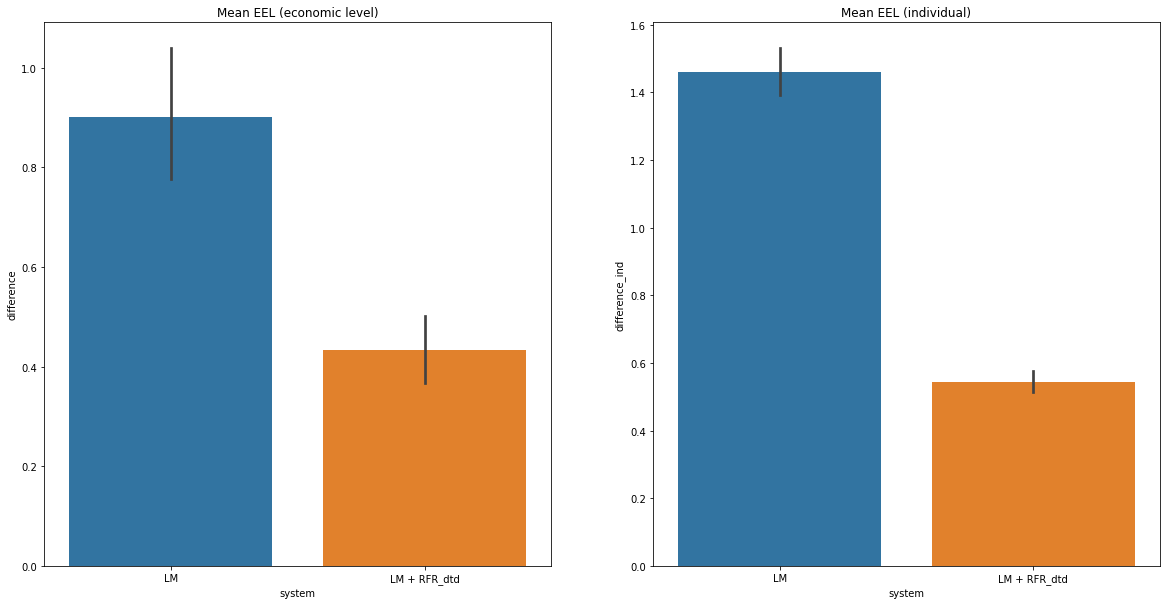

In [29]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)

axs[0].set_title('Mean EEL (economic level)')
axs[1].set_title('Mean EEL (individual)')

_ = sns.barplot(x='system', y='difference',data=data,ax=axs[0])
_ = sns.barplot(x='system', y='difference_ind',data=data,ax=axs[1])


## Is there a significant improvement in the performance of LambdaMart + AC vs LambdaMart without AC?

### Select data

In [30]:
s1 = 'lambdamart_mrfr_default_default_random_state=0'
s2 = 'ac_controller_default_lm'

In [31]:
data = experiments[(experiments.source == s1) | (experiments.source == s2)]
data = data.reset_index(drop=True)
data

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source,system
0,0.23910,1.42244,1.24913,0.14971,0.03529,0.01117,95,ac_controller_default_lm,LM + AC_dtd
1,0.76381,1.77053,1.38972,0.44681,0.17976,0.08696,612,ac_controller_default_lm,LM + AC_dtd
2,2.69675,1.76200,0.32276,0.77073,0.11388,0.06241,657,ac_controller_default_lm,LM + AC_dtd
3,0.17600,1.81185,1.29111,0.67444,0.25027,0.17895,771,ac_controller_default_lm,LM + AC_dtd
4,0.37616,1.73422,1.56520,0.48771,0.31650,0.20156,822,ac_controller_default_lm,LM + AC_dtd
...,...,...,...,...,...,...,...,...,...
395,0.08143,2.04229,1.69374,0.93860,1.07937,0.16915,119231,lambdamart_mrfr_default_default_random_state=0,LM
396,0.01894,2.14721,1.95367,0.52595,1.08236,0.66969,123512,lambdamart_mrfr_default_default_random_state=0,LM
397,0.14381,1.35630,0.97958,1.26812,1.26668,0.08817,126740,lambdamart_mrfr_default_default_random_state=0,LM
398,0.07780,1.59339,1.24696,1.26301,1.26668,0.28898,128050,lambdamart_mrfr_default_default_random_state=0,LM


In [32]:
from scipy import stats
a = data.query(f'source == "{s1}"').reset_index(drop=True)
b = data.query(f'source == "{s2}"').reset_index(drop=True)

### t-test eel

In [33]:
asub = a['difference']
bsub = b['difference']

In [34]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=8.44677447541935, pvalue=6.236384153314033e-15)

The difference in scores is significant, p = 0.00000 < 0.05.

In [35]:
effect_size_t_test(asub,bsub)

0.6

The effect size is moderate.

In [36]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [37]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,2), round(ch,2)

(0.37, 0.6)

In [38]:
round(sample_mean,2)

0.49

In [39]:
round(sample_variance,2)

0.66

### t-test eel_ind

In [40]:
from scipy import stats
asub = a['difference_ind']
bsub = b['difference_ind']

In [41]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=29.735506623400884, pvalue=3.7837131403965134e-75)

The difference in scores is significant, p = 0.00000 < 0.05.

In [42]:
effect_size_t_test(asub,bsub)

2.11

The effect size is moderate.

In [43]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [44]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,2), round(ch,2)

(0.88, 1.01)

In [45]:
round(sample_mean,2)

0.95

In [46]:
round(sample_variance,2)

0.2

### Visualize means of the samples

<AxesSubplot:title={'center':'Mean EEL (individual)'}, xlabel='system', ylabel='difference_ind'>

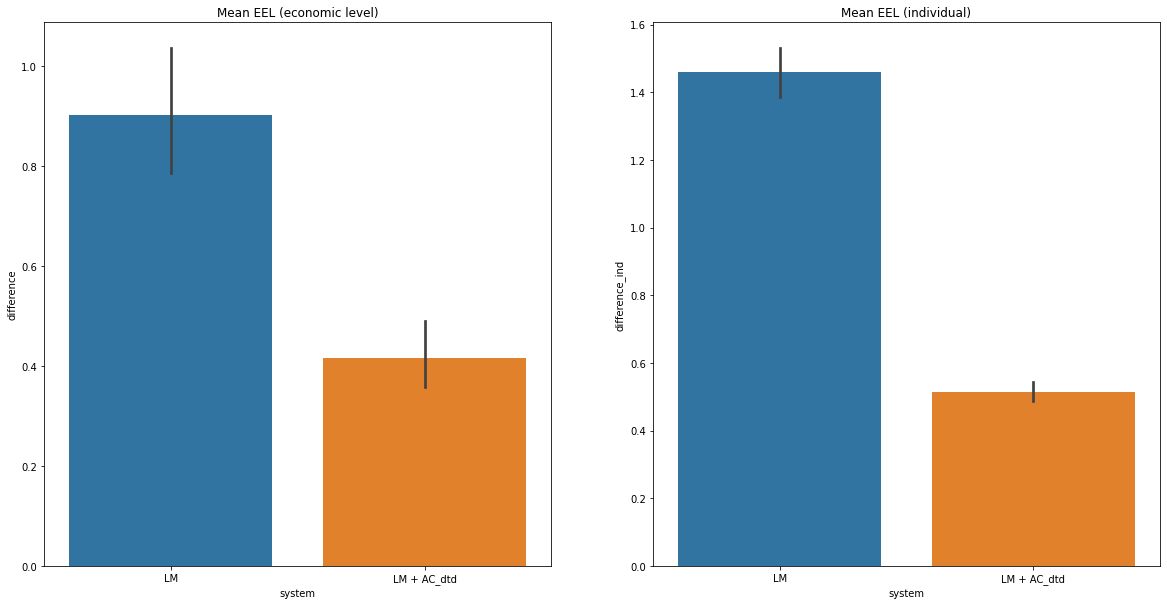

In [47]:
fig, axs = plt.subplots(1,2,figsize=(20,10))
# for ax in axs:
#     ax.set_ylim(0, ymax)


axs[0].set_title('Mean EEL (economic level)')
axs[1].set_title('Mean EEL (individual)')

sns.barplot(x='system', y='difference',data=data.sort_values(by='system',ascending=True),ax=axs[0])
sns.barplot(x='system', y='difference_ind',data=data.sort_values(by='system',ascending=True),ax=axs[1])


## Is there a significant improvement in the performance of LambdaMart + RFR vs LambdaMart + AC?

### Select data

In [48]:
s1 = 'mrfr_default_lm_eval'
s2 = 'ac_controller_default_lm'

In [49]:
data = experiments[(experiments.source == s1) | (experiments.source == s2)]
data = data.reset_index(drop=True)
data

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source,system
0,0.23910,1.42244,1.24913,0.14971,0.03529,0.01117,95,ac_controller_default_lm,LM + AC_dtd
1,0.76381,1.77053,1.38972,0.44681,0.17976,0.08696,612,ac_controller_default_lm,LM + AC_dtd
2,2.69675,1.76200,0.32276,0.77073,0.11388,0.06241,657,ac_controller_default_lm,LM + AC_dtd
3,0.17600,1.81185,1.29111,0.67444,0.25027,0.17895,771,ac_controller_default_lm,LM + AC_dtd
4,0.37616,1.73422,1.56520,0.48771,0.31650,0.20156,822,ac_controller_default_lm,LM + AC_dtd
...,...,...,...,...,...,...,...,...,...
395,0.06794,2.07851,1.71860,0.07524,0.15761,0.13995,119231,mrfr_default_lm_eval,LM + RFR_dtd
396,0.10978,2.17396,1.92162,0.57496,0.35774,0.28288,123512,mrfr_default_lm_eval,LM + RFR_dtd
397,0.27117,1.42900,0.95225,0.16322,0.19395,0.10425,126740,mrfr_default_lm_eval,LM + RFR_dtd
398,0.48640,1.10121,0.79658,0.40619,0.19921,0.18365,128050,mrfr_default_lm_eval,LM + RFR_dtd


In [50]:
from scipy import stats
a = data.query(f'source == "{s1}"').reset_index(drop=True)
b = data.query(f'source == "{s2}"').reset_index(drop=True)

### t-test eel

In [51]:
asub = a['difference']
bsub = b['difference']

In [52]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=1.7950070184937754, pvalue=0.0741700961450265)

The difference in scores is NOT significant, p = 0.074 > 0.05.

In [53]:
effect_size_t_test(asub,bsub)

0.13

The effect size is moderate.

In [54]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [55]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,4), round(ch,3)

(-0.0016, 0.036)

In [56]:
round(sample_mean,3)

0.017

In [57]:
round(sample_variance,3)

0.018

### t-test eel_ind

In [58]:
from scipy import stats
asub = a['difference_ind']
bsub = b['difference_ind']

In [59]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=6.10780487621202, pvalue=5.214855259867564e-09)

The difference in scores is significant, p = 0.00000 < 0.05.

In [60]:
effect_size_t_test(asub,bsub)

0.43

The effect size is moderate.

In [61]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [62]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,3), round(ch,3)

(0.021, 0.041)

In [63]:
round(sample_mean,4)

0.0313

In [64]:
round(sample_variance,4)

0.0052

### Visualize means of the samples

<AxesSubplot:title={'center':'Mean EEL (individual)'}, xlabel='system', ylabel='difference_ind'>

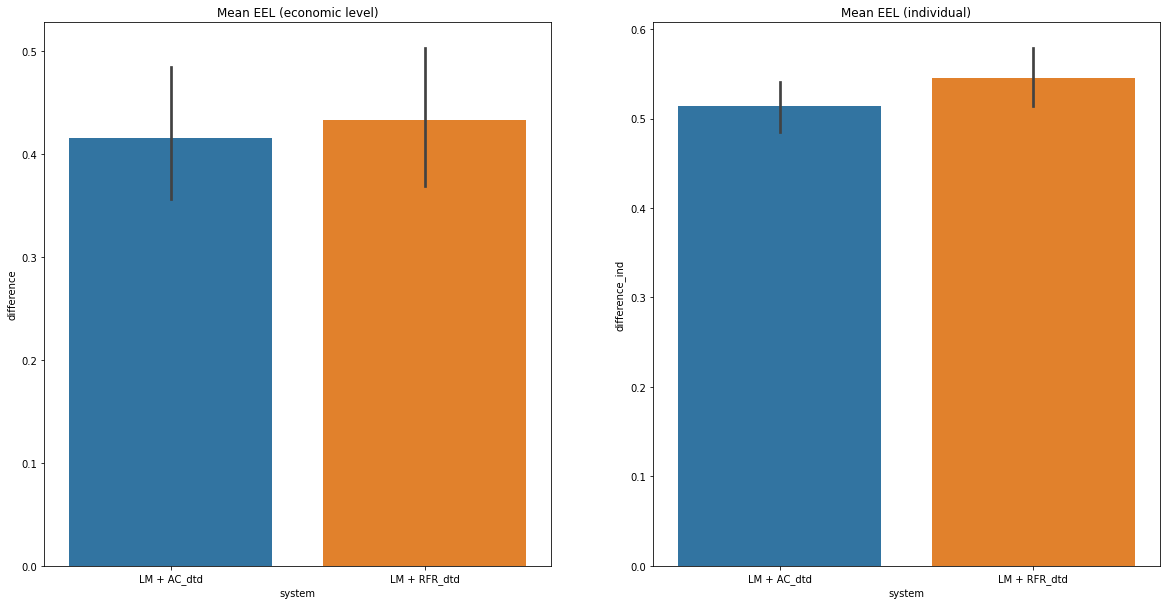

In [65]:
fig, axs = plt.subplots(1,2,figsize=(20,10))

axs[0].set_title('Mean EEL (economic level)')
axs[1].set_title('Mean EEL (individual)')

sns.barplot(x='system', y='difference',data=data,ax=axs[0])
sns.barplot(x='system', y='difference_ind',data=data,ax=axs[1])


## Is there a significant improvement in the performance of AC base vs AC doc to doc for META?

### Select data

In [66]:
experiments.source.unique()

array(['ac_controller_default_lm',
       'ac_controller_default_meta_9_eval_old_config',
       'ac_controller_default_meta_9_eval',
       'ac_controller_default_text_9_eval_old_config',
       'ac_controller_default_text_9_eval',
       'lambdamart_mrfr_default_default_random_state=0',
       'mrfr_default_lm_eval'], dtype=object)

In [67]:
s2 = 'ac_controller_default_meta_9_eval'
s1 = 'ac_controller_default_meta_9_eval_old_config'

In [68]:
data = experiments[(experiments.source == s1) | (experiments.source == s2)]
data = data.reset_index(drop=True)
data

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source,system
0,0.35200,2.93676,1.94984,1.11692,0.98604,0.00293,95,ac_controller_default_meta_9_eval_old_config,META + AC_base
1,0.99169,1.73147,1.25625,0.37762,0.12248,0.09292,612,ac_controller_default_meta_9_eval_old_config,META + AC_base
2,3.70055,2.63171,0.25572,0.93072,0.21487,0.03291,657,ac_controller_default_meta_9_eval_old_config,META + AC_base
3,0.29945,1.98737,1.31715,0.67458,0.17690,0.14219,771,ac_controller_default_meta_9_eval_old_config,META + AC_base
4,0.71517,1.65668,1.35692,0.57742,0.34905,0.17297,822,ac_controller_default_meta_9_eval_old_config,META + AC_base
...,...,...,...,...,...,...,...,...,...
395,0.15056,2.44868,1.86237,0.10874,0.13291,0.11085,119231,ac_controller_default_meta_9_eval,META + AC_dtd
396,0.15217,2.10207,1.86449,0.58399,0.30692,0.25295,123512,ac_controller_default_meta_9_eval,META + AC_dtd
397,0.12025,1.31108,0.96875,0.11039,0.10157,0.08447,126740,ac_controller_default_meta_9_eval,META + AC_dtd
398,0.69143,1.23131,0.75911,0.46638,0.17588,0.14189,128050,ac_controller_default_meta_9_eval,META + AC_dtd


In [69]:
from scipy import stats
a = data.query(f'source == "{s1}"').reset_index(drop=True)
b = data.query(f'source == "{s2}"').reset_index(drop=True)

### t-test eel

In [70]:
asub = a['difference']
bsub = b['difference']

In [71]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=1.8990881102419774, pvalue=0.05899949442741354)

The difference in scores is NOT significant, p = 0.059 > 0.05.

In [72]:
effect_size_t_test(asub,bsub)

0.13

The effect size is moderate.

In [73]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [74]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,3), round(ch,3)

(-0.001, 0.052)

In [75]:
round(sample_mean,3)

0.026

In [76]:
round(sample_variance,3)

0.037

### t-test eel_ind

In [77]:
from scipy import stats
asub = a['difference_ind']
bsub = b['difference_ind']

In [78]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=6.8041298125525, pvalue=1.1663991747847864e-10)

The difference in scores is significant, p = 0.00000 < 0.05.

In [79]:
effect_size_t_test(asub,bsub)

0.48

The effect size is moderate.

In [80]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [81]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,3), round(ch,3)

(0.055, 0.099)

In [82]:
round(sample_mean,3)

0.077

In [83]:
round(sample_variance,3)

0.025

### Visualize means of the samples

<AxesSubplot:title={'center':'Mean EEL (individual)'}, xlabel='system', ylabel='difference_ind'>

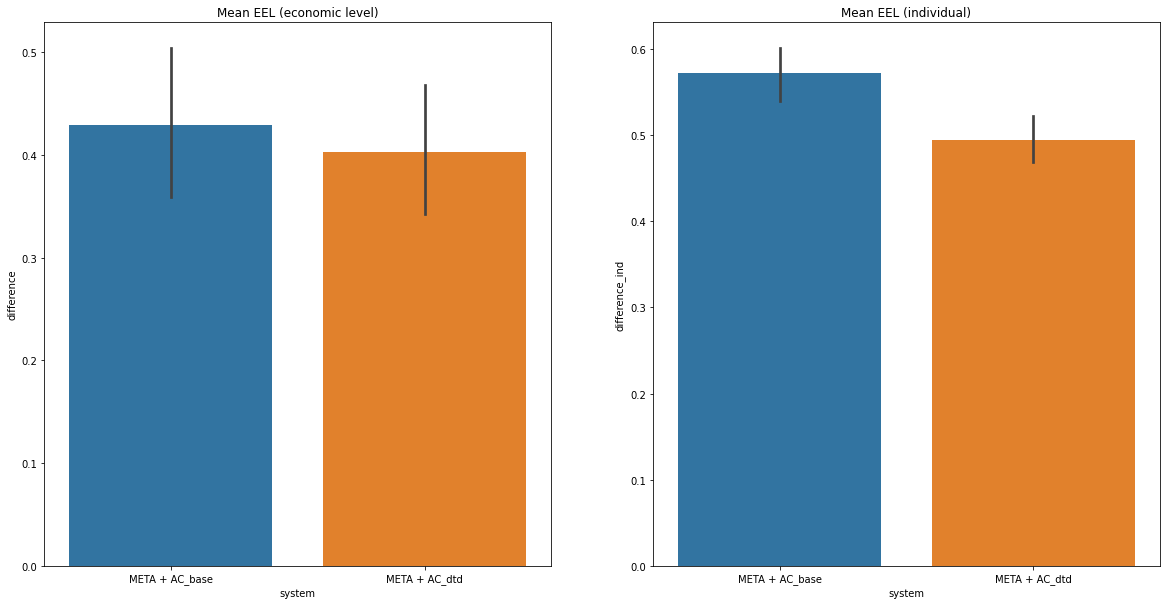

In [84]:
fig, axs = plt.subplots(1,2,figsize=(20,10))

axs[0].set_title('Mean EEL (economic level)')
axs[1].set_title('Mean EEL (individual)')

sns.barplot(x='system', y='difference',data=data,ax=axs[0])
sns.barplot(x='system', y='difference_ind',data=data,ax=axs[1])


## Is there a significant improvement in the performance of AC base vs AC doc to doc for TEXT?

### Select data

In [85]:
s2 = 'ac_controller_default_text_9_eval'
s1 = 'ac_controller_default_text_9_eval_old_config'

In [86]:
data = experiments[(experiments.source == s1) | (experiments.source == s2)]
data = data.reset_index(drop=True)
data

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source,system
0,0.46567,3.25201,2.05063,0.97818,0.84548,0.00203,95,ac_controller_default_text_9_eval_old_config,TEXT + AC_base
1,1.06389,1.76208,1.23545,0.39826,0.12153,0.08212,612,ac_controller_default_text_9_eval_old_config,TEXT + AC_base
2,3.92328,2.83716,0.24707,1.00489,0.28676,0.03177,657,ac_controller_default_text_9_eval_old_config,TEXT + AC_base
3,0.33006,2.02984,1.32308,0.69114,0.17594,0.13344,771,ac_controller_default_text_9_eval_old_config,TEXT + AC_base
4,0.75494,1.65849,1.33794,0.59382,0.35730,0.16890,822,ac_controller_default_text_9_eval_old_config,TEXT + AC_base
...,...,...,...,...,...,...,...,...,...
395,0.13398,2.38984,1.84124,0.10291,0.13054,0.11258,119231,ac_controller_default_text_9_eval,TEXT + AC_dtd
396,0.14900,2.09805,1.86406,0.57226,0.30555,0.25813,123512,ac_controller_default_text_9_eval,TEXT + AC_dtd
397,0.12853,1.35327,0.98570,0.11874,0.10143,0.08023,126740,ac_controller_default_text_9_eval,TEXT + AC_dtd
398,0.67161,1.23895,0.77284,0.46805,0.17496,0.14059,128050,ac_controller_default_text_9_eval,TEXT + AC_dtd


In [87]:
from scipy import stats
a = data.query(f'source == "{s1}"').reset_index(drop=True)
b = data.query(f'source == "{s2}"').reset_index(drop=True)

### t-test eel

In [88]:
asub = a['difference']
bsub = b['difference']

In [89]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=2.395531305600646, pvalue=0.01752296958297589)

The difference in scores is significant, p = 0.00000 < 0.05.

In [90]:
effect_size_t_test(asub,bsub)

0.17

The effect size is moderate.

In [91]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [92]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,4), round(ch,4)

(0.0063, 0.0642)

In [93]:
round(sample_mean,3)

0.035

In [94]:
round(sample_variance,3)

0.043

### t-test eel_ind

In [95]:
from scipy import stats
asub = a['difference_ind']
bsub = b['difference_ind']

In [96]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=7.029660922505702, pvalue=3.2345039464592856e-11)

The difference in scores is significant, p = 0.00000 < 0.05.

In [97]:
effect_size_t_test(asub,bsub)

0.5

The effect size is moderate.

In [98]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [99]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(0.06466, 0.11489)

In [100]:
round(sample_mean,5)

0.08978

In [101]:
round(sample_variance,5)

0.03246

### Visualize means of the samples

<AxesSubplot:title={'center':'Mean EEL (individual)'}, xlabel='system', ylabel='difference_ind'>

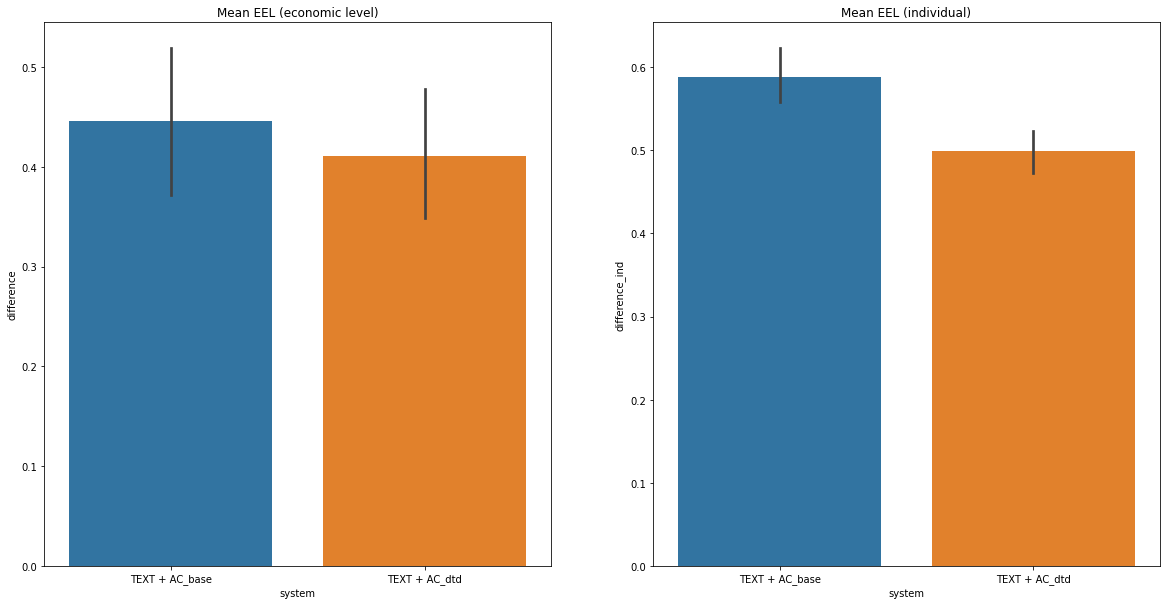

In [102]:
fig, axs = plt.subplots(1,2,figsize=(20,10))

axs[0].set_title('Mean EEL (economic level)')
axs[1].set_title('Mean EEL (individual)')

sns.barplot(x='system', y='difference',data=data,ax=axs[0])
sns.barplot(x='system', y='difference_ind',data=data,ax=axs[1])


## Is there a significant difference between the TREC mean and AC(dtd) or RFR(dtd)?

### Select data

In [103]:
s1 = 'ac_controller_default_lm'
s2 = 'mrfr_default_lm_eval'

In [104]:
data = experiments[(experiments.source == s1) | (experiments.source == s2)]
data = data.reset_index(drop=True)
data

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source,system
0,0.23910,1.42244,1.24913,0.14971,0.03529,0.01117,95,ac_controller_default_lm,LM + AC_dtd
1,0.76381,1.77053,1.38972,0.44681,0.17976,0.08696,612,ac_controller_default_lm,LM + AC_dtd
2,2.69675,1.76200,0.32276,0.77073,0.11388,0.06241,657,ac_controller_default_lm,LM + AC_dtd
3,0.17600,1.81185,1.29111,0.67444,0.25027,0.17895,771,ac_controller_default_lm,LM + AC_dtd
4,0.37616,1.73422,1.56520,0.48771,0.31650,0.20156,822,ac_controller_default_lm,LM + AC_dtd
...,...,...,...,...,...,...,...,...,...
395,0.06794,2.07851,1.71860,0.07524,0.15761,0.13995,119231,mrfr_default_lm_eval,LM + RFR_dtd
396,0.10978,2.17396,1.92162,0.57496,0.35774,0.28288,123512,mrfr_default_lm_eval,LM + RFR_dtd
397,0.27117,1.42900,0.95225,0.16322,0.19395,0.10425,126740,mrfr_default_lm_eval,LM + RFR_dtd
398,0.48640,1.10121,0.79658,0.40619,0.19921,0.18365,128050,mrfr_default_lm_eval,LM + RFR_dtd


In [105]:
from scipy import stats
a = data.query(f'source == "{s1}"').reset_index(drop=True)
b = data.query(f'source == "{s2}"').reset_index(drop=True)


### AC vs TREC mean

#### t-test eel

In [106]:
bsub = a['difference']
asub = trec_means['difference']

In [107]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=16.78410588450395, pvalue=5.693036640327242e-40)

The difference in scores is significant, p = 0.00000 < 0.05.

In [108]:
effect_size_t_test(asub,bsub)

1.19

The effect size is LARGE.

In [109]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [110]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,4), round(ch,4)

(0.2943, 0.3725)

In [111]:
round(sample_mean,3)

0.333

In [112]:
round(sample_variance,3)

0.079

#### t-test eel_ind

In [113]:
from scipy import stats
bsub = a['difference_ind']
asub = trec_means['difference_ind']

In [114]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=54.023986838259866, pvalue=7.3623814442948135e-121)

The difference in scores is significant, p = 0.00000 < 0.05.

In [115]:
effect_size_t_test(asub,bsub)

3.83

The effect size is moderate.

In [116]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [117]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(0.63307, 0.68092)

In [118]:
round(sample_mean,5)

0.657

In [119]:
round(sample_variance,5)

0.02943

### RFR vs TREC mean

#### t-test eel

In [122]:
bsub = b['difference']
asub = trec_means['difference']

In [123]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=14.336322090270897, pvalue=1.742637089060394e-32)

The difference in scores is significant, p = 0.00000 < 0.05.

In [124]:
effect_size_t_test(asub,bsub)

1.02

The effect size is LARGE.

In [125]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [126]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,4), round(ch,4)

(0.2729, 0.3597)

In [127]:
round(sample_mean,3)

0.316

In [128]:
round(sample_variance,3)

0.097

#### t-test eel_ind

In [129]:
from scipy import stats
bsub = b['difference_ind']
asub = trec_means['difference_ind']

In [130]:
stats.ttest_rel(asub, bsub)

Ttest_relResult(statistic=45.26272568938296, pvalue=1.0221820503766304e-106)

The difference in scores is significant, p = 0.00000 < 0.05.

In [131]:
effect_size_t_test(asub,bsub)

3.21

The effect size is moderate.

In [132]:
differences = asub - bsub
sample_mean = differences.sum()/len(differences)
sample_variance = (differences - sample_mean).apply(lambda x: x*x).sum()/len(differences)

In [133]:
c = ci(len(differences), sample_variance)
cl, ch = (sample_mean - c, sample_mean + c)
round(cl,5), round(ch,5)

(0.5985, 0.65288)

In [134]:
round(sample_mean,5)

0.62569

In [135]:
round(sample_variance,5)

0.03803

### Visualize means of the samples

In [136]:
plotdata = pd.concat([data,trec_means])
plotdata

,difference,disparity,relevance,difference_ind,disparity_ind,relevance_ind,qid,source,system
0,0.23910,1.42244,1.24913,0.14971,0.03529,0.01117,95,ac_controller_default_lm,LM + AC_dtd
1,0.76381,1.77053,1.38972,0.44681,0.17976,0.08696,612,ac_controller_default_lm,LM + AC_dtd
2,2.69675,1.76200,0.32276,0.77073,0.11388,0.06241,657,ac_controller_default_lm,LM + AC_dtd
3,0.17600,1.81185,1.29111,0.67444,0.25027,0.17895,771,ac_controller_default_lm,LM + AC_dtd
4,0.37616,1.73422,1.56520,0.48771,0.31650,0.20156,822,ac_controller_default_lm,LM + AC_dtd
...,...,...,...,...,...,...,...,...,...
195,0.35149,2.34169,1.70841,0.77897,0.83099,0.12478,119231,NaN,TREC mean
196,0.42510,2.49884,1.92640,1.21086,0.93900,0.25556,123512,NaN,TREC mean
197,0.48605,1.60679,0.93370,0.85543,0.83660,0.07948,126740,NaN,TREC mean
198,0.80032,1.39898,0.78851,0.78801,0.85329,0.31978,128050,NaN,TREC mean


<AxesSubplot:title={'center':'Mean EEL (individual)'}, xlabel='system', ylabel='difference_ind'>

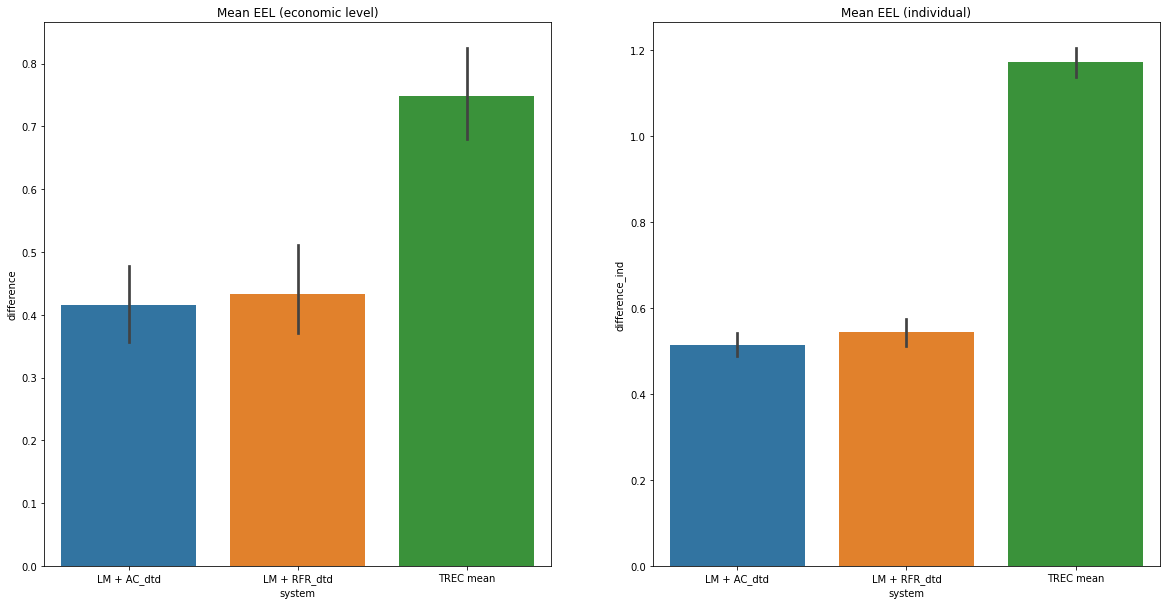

In [137]:
fig, axs = plt.subplots(1,2,figsize=(20,10))

axs[0].set_title('Mean EEL (economic level)')
axs[1].set_title('Mean EEL (individual)')

sns.barplot(x='system', y='difference',data=plotdata,ax=axs[0])
sns.barplot(x='system', y='difference_ind',data=plotdata,ax=axs[1])
